In [1]:
from scipy.optimize         import newton
from sklearn.neighbors      import KDTree
from scipy.sparse           import csr_matrix
from scipy.sparse.csgraph   import dijkstra
from scipy.linalg           import eig
from sklearn.decomposition  import PCA
import numpy                as np
import gudhi                as gd
import warnings
import gurobipy             as gp
from gurobipy               import GRB
import matplotlib.pyplot    as plt
from kneed                  import KneeLocator
from scipy.spatial          import distance_matrix
from ripser                 import Rips
from sklearn.preprocessing  import PolynomialFeatures
import sympy                as sp
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem     import Problem
from pymoo.optimize         import minimize
import tadasets
import rml

In [5]:
params = {'max_components':5, 'S':0.5, 'k':10, 'threshold_var':0.05, 'edge_sen':1, 'k0':2, 'beta':[0.7, 100, 1, 1]}  # change edge sen
sphere5 = tadasets.dsphere(n=int(1500*1.3))
sphere5 = sphere5[sphere5[:, 2]>=-0.7]
S = rml.Simplex()
S.build_simplex(sphere5, **params)

In [6]:
S.dim

2

In [7]:
_ = S.normal_coords_trade(**params)

768
67


In [8]:
from scipy.spatial import Delaunay

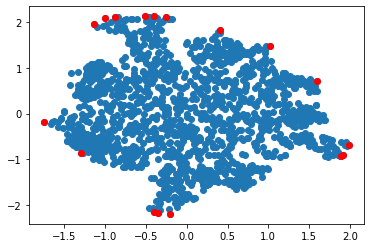

In [9]:
T = Delaunay(S.coords)

# Find edges at the boundary
boundary = set()
for i in range(len(T.neighbors)):
    for k in range(3):
        if (T.neighbors[i][k] == -1):
            nk1,nk2 = (k+1)%3, (k+2)%3 
            boundary.add(T.simplices[i][nk1])
            boundary.add(T.simplices[i][nk2])

plt.scatter(S.coords[:,0], S.coords[:,1])
plt.plot(S.coords[list(boundary),0], S.coords[list(boundary),1], 'or')
plt.show()

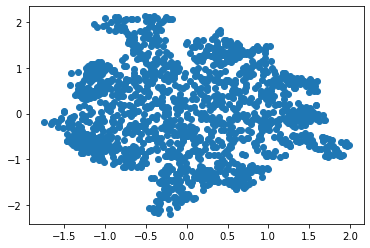

In [10]:
plt.scatter(S.coords[:,0], S.coords[:,1])

In [3]:
A, y, alpha, c_1, c_1_prime, c_2, c_2_prime, q, b_prime = S.normal_coords_trade(**params)

Restricted license - for non-production use only - expires 2023-10-25
188
5


In [4]:
print(A)
print(y)
print(alpha)
print(c_1)
print(c_1_prime)
print(c_2)
print(c_2_prime)
print(q)
print(b_prime)

[[ 26.29969126   9.29519192]
 [ 22.23348125  16.84478153]
 [ 13.78615902 -24.24904478]
 [ 24.26008194  13.76672719]]
[-0.62950281  0.45057816 -0.85468544  0.10751879]
0.03585002392296506
[0.89813307 0.3909764  0.20123231]
[-1.34461127 -0.23357973]
[0.91257767 0.36003797 0.19384183]
[-1.08660363 -0.03063533]
[0.91463204 0.37248418 0.15717435]
[-1.36309167 -0.24011132]


In [10]:
m = gp.Model()
m.setParam('OutputFlag', 0)
m.setParam(GRB.Param.NonConvex, 2)

x = m.addMVar(shape=2, lb=float('-inf'))
z = m.addMVar(shape=2, lb=float('-inf'))
z2 = m.addMVar(shape=2, lb=float('-inf'))

Q = A.T @ A
c = -2 * y.T @ A
obj = x @ Q @ x + c @ x + y.T @ y

m.setObjective(obj, GRB.MINIMIZE)

c0 = m.addConstr(x@x == alpha**2, name="c0")

c1 = m.addConstr(z == x+b_prime-c_1_prime, name="d0")
d1 = m.addConstr(z@z == (q-c_1)@(q-c_1), name="d0")

c2 = m.addConstr(z2 == x+b_prime-c_2_prime, name="d2")
d2 = m.addConstr(z2@z2 == (q-c_2)@(q-c_2), name="d22")

m.feasRelax(relaxobjtype=1, minrelax=True, vars=None, lbpen=None, ubpen=None, constrs=[c0, d1, d2], rhspen=[100, 10, 1])

m.optimize()

In [11]:
x.X

GurobiError: Unable to retrieve attribute 'X'

In [22]:
m.status

2

In [23]:
np.asarray(x.X) @ np.asarray(x.X)

0.002977433436283547

In [24]:
alpha**2

0.002976916618552265